In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

In [3]:
from stopro.data_preparer.data_preparer import DataPreparer
from stopro.sub_modules.load_modules import load_params, load_data
from stopro.data_handler.data_handle_module import HdfOperator
from stopro.sub_modules.init_modules import get_init, reshape_init

In [4]:
project_name = 'data'
simulation_name = 'test_loss_sin1d_naive_y_1000_x100'

In [5]:
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [6]:
# prepare data
hdf_operator = HdfOperator(f"{project_name}/{simulation_name}")
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = np.empty(0)
for i in range(len(r_train)):
    delta_y_train = np.append(delta_y_train, f_train[i] - μ_train[i])

args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]
noise = params_model["epsilon"]

In [7]:
train_x = torch.from_numpy(np.array(r_train[0]))

In [8]:
train_y = torch.from_numpy(np.array(f_train[0]))

In [9]:
test_x = torch.from_numpy(np.array(r_test[0]))

In [10]:
noise_constraint = gpytorch.constraints.Interval(1e-3, 1e-2)

In [44]:
# set up the model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # RBFKernelにはscaleのパラメータが含まれていないため、ScaleKernelで囲む
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize liklihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=noise_constraint)
model = ExactGPModel(train_x, train_y, likelihood)

In [54]:
## set initial values
model.covar_module.base_kernel.lengthscale = torch.tensor([1.])
model.covar_module.outputscale = torch.tensor([1.])
print('lengthscale : %.3e  outputscale: %.3e' % (
                model.covar_module.base_kernel.lengthscale.item(),
                model.covar_module.outputscale
            ))

lengthscale : 1.000e+00  outputscale: 1.000e+00


In [55]:
model.covar_module.parameters

<bound method Module.parameters of ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
    (distance_module): Distance()
  )
  (raw_outputscale_constraint): Positive()
)>

In [57]:
def training_function():
    loss_converge=False
    loss_previous = 10000
    # training the model
    training_iter =300

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(
        # covar_moduleの中のパラメータのみ最適化
        [
            {'params': model.covar_module.parameters()},
        ], lr = 0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i % 50 == 0:
            print('Iter %d/%d - Loss : %.3f  outputscale : %.3f  lengthscale : %.3f  noise: %.3e' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.outputscale,
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()
        if abs(loss_previous - loss.item()) < 0.0001:
            if loss_converge:
                break
            else:
                loss_converge=True
        else:
            loss_converge=False
            
        loss_previous = loss.item()

In [58]:
def predicting_function():
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0, 1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # 勾配の計算が不要な場合はwith torch.no_grad()にする
        observed_pred = likelihood(model(test_x))
    return observed_pred

In [59]:
training_function()

Iter 1/300 - Loss : -0.013  outputscale : 1.000  lengthscale : 1.000  noise: 5.500e-03
Iter 51/300 - Loss : -1.203  outputscale : 0.172  lengthscale : 3.850  noise: 5.500e-03
Iter 101/300 - Loss : -1.287  outputscale : 0.189  lengthscale : 5.369  noise: 5.500e-03
Iter 151/300 - Loss : -1.352  outputscale : 0.197  lengthscale : 6.572  noise: 5.500e-03
Iter 201/300 - Loss : -1.382  outputscale : 0.208  lengthscale : 7.619  noise: 5.500e-03
Iter 251/300 - Loss : -1.400  outputscale : 0.211  lengthscale : 8.592  noise: 5.500e-03


In [60]:
with torch.no_grad():
    print(model.covar_module.outputscale)
    print(model.covar_module.base_kernel.lengthscale.item())

tensor(0.2316)
9.501313209533691


In [61]:
observed_pred = predicting_function()

In [62]:
# Make predictions with the model
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

# f_samples = f_preds.sample(sample_shape= torch.Size([1000],))

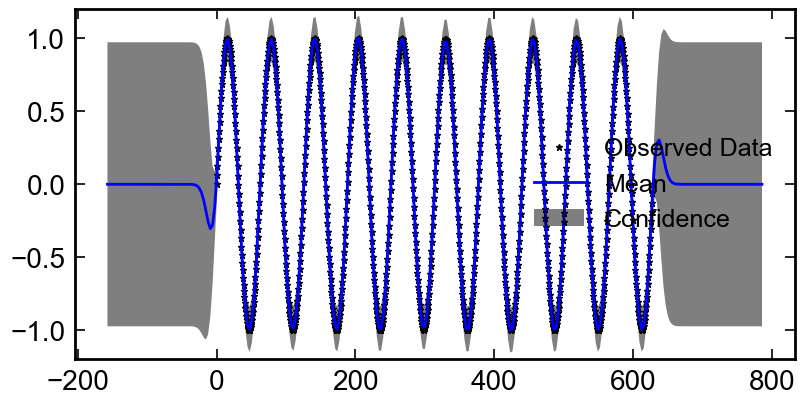

In [63]:
with torch.no_grad():
    fig, ax  = plt.subplots(1, 1, figsize=(10, 5))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region() # 2 standard deviations
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', ms=5)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1.2, 1.2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [23]:
lower?

Type:        Tensor
String form:
tensor([-0.7806, -0.7806, -0.7806, -0.7806, -0.7806, -0.7806, -0.7806, -0.7806,
           -0.7806,  <...> 0.7806, -0.7806, -0.7806, -0.7806, -0.7806, -0.7806,
           -0.7806, -0.7806, -0.7806, -0.7806])
Length:      300
File:        ~/.conda/envs/mytorch/lib/python3.9/site-packages/torch/__init__.py
Docstring:   <no docstring>
